# Dive into the Competition

https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries

## Imports

In [1]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
sys.path.append(parent_dir)

from utils import download_competition_data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit

In [3]:
plt.style.use('ggplot')

## Solution Workflow

1. Understand the Problem
    - Data type: tabular data, time series, images, text, ...
    - Problem type: classification, regression, ranking, ...
    - Evaluation metrics: ROC AUC, F1-Score, MAE, MSE, ...
2. Initial EDA
    - size of data
    - properties of the target variable
    - properties of the features
    - generate ideas for feature engineering
3. Local Validation (prevent overfitting)
4. Modeling

## Step 1: Understand the Problem

### Problem Statement

Predict the popularity of an apartment rental listing

### Target Variable

`interest_level`

### Problem Type

Classification with 3 classes:
- 'high'
- 'medium'
- 'low'

### Metric

Multi-class logarithmic loss.

Each listing has one true class. For each listing, you must submit a set of predicted probabilities (one for every listing). The formula is then,

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} \log(p_{ij})
$$

$log$ is the natural logarithm
<br/>
$N$: Number of samples in the dataset
<br/>
$M$: Number of classes (in our case it is 3)
<br/>
$y_{ij}$: Indicator variable that equals 1 if the true class of sample $i$ is $j$, and 0 otherwise
<br/>
$p_{ij}$: Predicted probability that sample $i$ belongs to class $j$, outputted by the model (e.g. from softmax)

<br/><br/>

The submitted probabilities for a given listing are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with $max(min(p,1−10^{−15}),10^{−15})$

In [4]:
def avoid_extremes(p):
    arg1 = np.min([p, 1 - 1e-15])
    arg2 = 10e-15
    return np.max([arg1, arg2])

avoid_extremes(0), avoid_extremes(0.5), avoid_extremes(1)

(1e-14, 0.5, 0.999999999999999)

## Step 2: Initial EDA

### The Data

In [5]:
download_competition_data('two-sigma-connect-rental-listing-inquiries')

Checking contents of '/Users/paul/Documents/repos/Kaggle/two-sigma-connect-rental-listing-inquiries/data'... Found: ['Kaggle-renthop.torrent', 'test.json', 'train.json', 'images_sample', 'sample_submission.csv']
Data already exists in '/Users/paul/Documents/repos/Kaggle/two-sigma-connect-rental-listing-inquiries/data'. Skipping download.


In [6]:
train = pd.read_json('data/train.json')
train['listing_id'] = train['listing_id'].astype(str)
train['interest_level'] = pd.Categorical(train['interest_level'], categories=['low', 'medium', 'high'], ordered=True)
train.shape

(49352, 15)

In [7]:
test = pd.read_json('data/test.json')
test['listing_id']=test['listing_id'].astype(str)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74659 entries, 0 to 124010
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        74659 non-null  float64
 1   bedrooms         74659 non-null  int64  
 2   building_id      74659 non-null  object 
 3   created          74659 non-null  object 
 4   description      74659 non-null  object 
 5   display_address  74659 non-null  object 
 6   features         74659 non-null  object 
 7   latitude         74659 non-null  float64
 8   listing_id       74659 non-null  object 
 9   longitude        74659 non-null  float64
 10  manager_id       74659 non-null  object 
 11  photos           74659 non-null  object 
 12  price            74659 non-null  int64  
 13  street_address   74659 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 8.5+ MB


In [8]:
features_and_target = ['listing_id', 'bathrooms', 'bedrooms', 'building_id', 'latitude', 'longitude', 
                       'manager_id', 'price', 'interest_level']
features = features_and_target[:-1]

In [9]:
train = train[features_and_target]
test = test[features]

### Target Variable

In [10]:
train['interest_level'].value_counts()

interest_level
low       34284
medium    11229
high       3839
Name: count, dtype: int64

### The features

In [11]:
train['listing_id'] = train['listing_id'].astype(str)

In [12]:
train.describe()

,bathrooms,bedrooms,latitude,longitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06


In [13]:
# find the median price by interest level
prices = train.groupby('interest_level', 
                       observed=False,
                       as_index=False)['price'].median()
prices = prices.sort_values('interest_level')  
prices

,interest_level,price
0,low,3300.0
1,medium,2895.0
2,high,2400.0


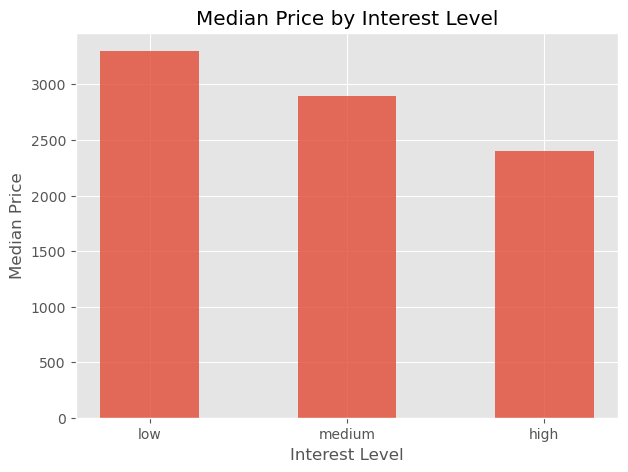

In [14]:
fig = plt.figure(figsize=(7, 5))
plt.bar(prices['interest_level'], prices['price'],
        width=0.5,
        alpha=0.8)

plt.xlabel('Interest Level')
plt.ylabel('Median Price')
plt.title('Median Price by Interest Level')

plt.show()

- Medium and high interest listings have lower prices
- People are searching for cheaper apartments
- A potentially useful new feature would be the price per bedroom

## Step 3: Local Validation

- Prevent Overfitting

### Holdout Set

- Split the train data into a **train set** and a **holdout set**
- Train on the **train set** and make predictions on the **holdout set**

### K-fold Cross-Validation

1. Split the data into `k` non-overlapping parts called "folds"
2. Train the model `k` times on all the data (**training set**) except for a single fold (**testing set**), choosing different fold to omit each time
3. Each time, we also measure the quality using the **testing set** 


In [15]:
# from sklearn.model_selection import KFold

# create a KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=123)
kf 

KFold(n_splits=5, random_state=123, shuffle=True)

In [16]:
# Loop through the splits
for train_indices, test_indices in kf.split(train):
    # get the training set and testing set for the current split
    cv_train, cv_test = train.iloc[train_indices], train.iloc[test_indices]
    all_counts = train['interest_level'].value_counts(normalize=True)
    train_counts = cv_train['interest_level'].value_counts(normalize=True)
    test_counts = cv_test['interest_level'].value_counts(normalize=True)
    print(pd.DataFrame({'all': all_counts,
                        'train': train_counts,
                        'test': test_counts}))

                     all     train      test
interest_level                              
low             0.694683  0.694765  0.694357
medium          0.227529  0.227552  0.227434
high            0.077788  0.077683  0.078209
                     all     train      test
interest_level                              
low             0.694683  0.694714  0.694560
medium          0.227529  0.226945  0.229865
high            0.077788  0.078341  0.075575
                     all     train      test
interest_level                              
low             0.694683  0.694595  0.695035
medium          0.227529  0.227927  0.225937
high            0.077788  0.077478  0.079027
                     all     train      test
interest_level                              
low             0.694683  0.694418  0.695745
medium          0.227529  0.227977  0.225735
high            0.077788  0.077605  0.078521
                     all     train      test
interest_level                              
low       

### Statified K-fold

- Creates stratified folds by target variable
- Better choice for an unbalanced dataset

In [17]:
# from sklearn.model_selection import StratifiedKFold

# create a StratifiedKFold object with 5 splits
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
strat_kf

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [18]:
# Loop through the splits
for train_indices, test_indices in strat_kf.split(train, train['interest_level']):
    # get the training set and testing set for the current split
    cv_train, cv_test = train.iloc[train_indices], train.iloc[test_indices]
    all_counts = train['interest_level'].value_counts(normalize=True)
    train_counts = cv_train['interest_level'].value_counts(normalize=True)
    test_counts = cv_test['interest_level'].value_counts(normalize=True)
    print(pd.DataFrame({'all': all_counts,
                        'train': train_counts,
                        'test': test_counts}))

                     all     train      test
interest_level                              
low             0.694683  0.694689  0.694661
medium          0.227529  0.227527  0.227535
high            0.077788  0.077784  0.077804
                     all     train      test
interest_level                              
low             0.694683  0.694689  0.694661
medium          0.227529  0.227527  0.227535
high            0.077788  0.077784  0.077804
                     all     train      test
interest_level                              
low             0.694683  0.694671  0.694732
medium          0.227529  0.227521  0.227558
high            0.077788  0.077808  0.077710
                     all     train      test
interest_level                              
low             0.694683  0.694696  0.694630
medium          0.227529  0.227521  0.227558
high            0.077788  0.077782  0.077812
                     all     train      test
interest_level                              
low       

### Validation Usage

#### Data Leakage

- Leakage causes a model to seem accurate, until we start making predictions in a real-world enivironment

##### Types of Data Leakage

1. Leak in features: using data that will not be available in the real setting
    - example: predicting sales in US dollars, while having exactly the same sales in UK pounds as a feature
2. Leak in validation strategy: validation strategy differs from the real-world situation
    - suppose we are solving the problem with time series data
    - as a validation strategy, we selected the usual k-fold
        - in the second split, we build a model using data from the future, which is a problem because in a real-world setting we will not have access to data from the future
        - <img src='images/img1.png'>
        - one possible fix for this is to use time k-fold cross-validation
        - <img src='images/img2.png'>

In [19]:
# from sklearn.model_selection import TimeSeriesSplit

# create a TimeSeriesSplit object with 5 splits
time_kf = TimeSeriesSplit(n_splits=5)
time_kf

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [20]:
# loop through the splits
for train_indices, test_indices in time_kf.split(train):
    # get the training set and testing set for the current split
    cv_train, cv_test = train.iloc[train_indices], train.iloc[test_indices]
    print(cv_train.shape, cv_test.shape)

(8227, 9) (8225, 9)
(16452, 9) (8225, 9)
(24677, 9) (8225, 9)
(32902, 9) (8225, 9)
(41127, 9) (8225, 9)


### Validation Pipeline